In [ ]:
!pip install PyPDF2 

In [ ]:
import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
list_of_files=(glob.glob("/content/drive/My Drive/Colab Notebooks/interns/*.pdf"))

In [ ]:
list_of_files

['/content/drive/My Drive/Colab Notebooks/interns/preethi sree 16h61a05g2 - PILLALAMARRI PREETHISREE.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/mahendra - SHETTI MAHENDRABABU.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/Copy-saketh resume - AWALA SAKETHREDDY.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/Resume Format - Aug 2019 - V2 (3)-converted - Vatte Pranay.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/resume intern1 - MADASU CHANDHANA.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/Resume rajesh 1 - Prince Rajesh.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/resume1 - S MOUNISHA.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/resume 01 (1) - JOSHI APOORVA.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/resume26-11 - AVULA SAI DINDIMAREDDY.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/Resume_latest - G SAIPRANAV.pdf',
 '/content/drive/My Drive/Colab Notebooks/interns/SADIYA AFSHAN(1)_29-Nov-19_1

In [ ]:
def pdfextract(file):
    # print(file)
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:    
        pageObj = fileReader.getPage(count)
        count +=1
        t = pageObj.extractText()
        # print (t)
        text.append(t)
    return text


In [ ]:
final_database=pd.DataFrame()
for i in list_of_files[:]:
  try:
    text = pdfextract(i) 
    text = str(text)
    text = text.replace("\\n", " ")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own

    keyword_dict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Skill Table - Sheet1.csv')
    stats_words = [nlp(text) for text in keyword_dict['STATISTICS'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['MACHINE LEARNING'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['DEEP LEARNING'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R LANGUAGE'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['PYTHON LANGUAGE'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['DATA ENGINEERING'].dropna(axis = 0)]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    base = os.path.basename(i)
    filename = os.path.splitext(base)[0]
        
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])

    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)
    final_database=final_database.append(dataf,ignore_index=1)
  except:
    continue


In [ ]:
final_database

,Candidate Name,Subject,Keyword,Count
0,preethi sree 16h61a05g2 - pillalamarri preethi...,Python,python,1
1,mahendra - shetti mahendrababu,NaN,NaN,NaN
2,copy-saketh resume - awala sakethreddy,Python,python,1
3,copy-saketh resume - awala sakethreddy,NLP,chatbot,1
4,copy-saketh resume - awala sakethreddy,NLP,nltk,1
5,copy-saketh resume - awala sakethreddy,ML,pca,1
6,resume format - aug 2019 - v2 (3)-converted - ...,NaN,NaN,NaN
7,resume intern1 - madasu chandhana,Python,python,1
8,resume intern1 - madasu chandhana,NLP,chatbot,1
9,resume intern1 - madasu chandhana,DL,opencv,2


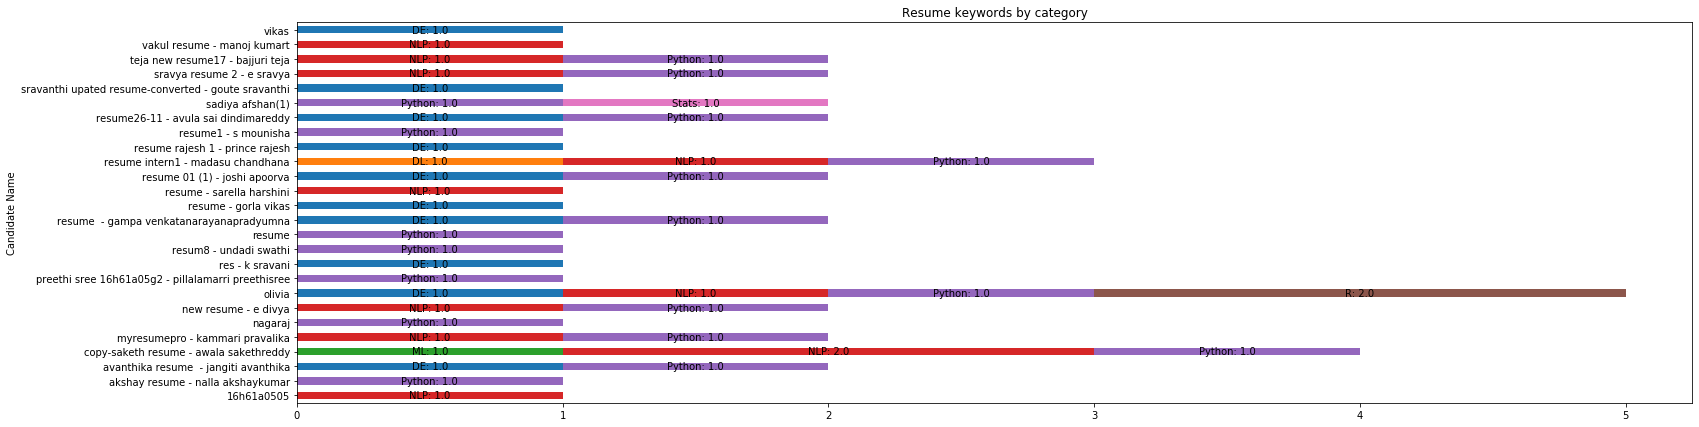

In [ ]:
final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']
#execute the below line if you want to see the candidate profile in a csv format
sample2=new_data.to_csv('sample.csv')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()
